# FDRI catchment gauge record vs gridded data at Carreg Wen

The rain gauge record is from Carreg-wen, Pembrokeshire

## Table of contents
[1 Analysis](#1-Analysis)  

In [658]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook')

# Load data

In [563]:
RAIN_COL = "rain_mm"
START_DATE = datetime.datetime(year=1976, month=1, day=1, hour=9)
END_DATE = datetime.datetime(year=2010, month=1, day=1, hour=9)
OVERLAP_THRESHOLD = 365*3 # three years

## Load CEH-GEAR

In [3]:
ceh_plynlimon = xr.open_dataset('../../../CEH_GEAR/ceh_1km_plynlimonregion_19760101_20101231.nc')
ceh_plynlimon = ceh_plynlimon.rename({'rainfall_amount': RAIN_COL})
ceh_plynlimon

<xarray.Dataset> Size: 810MB
Dimensions:   (time: 12784, y: 44, x: 45)
Coordinates:
  * x         (x) float64 360B 2.76e+05 2.77e+05 2.78e+05 ... 3.19e+05 3.2e+05
  * y         (y) float64 352B 2.58e+05 2.59e+05 2.6e+05 ... 3e+05 3.01e+05
  * time      (time) datetime64[ns] 102kB 1976-01-01 1976-01-02 ... 2010-12-31
Data variables:
    lat       (time, y, x) float64 202MB ...
    lon       (time, y, x) float64 202MB ...
    rain_mm   (time, y, x) float64 202MB ...
    min_dist  (time, y, x) float64 202MB ...
    crs       (time) int16 26kB ...
Attributes: (12/30)
    title:                CEH Gridded Estimates of Areal Rainfall (CEH - GEAR...
    institution:          CEH Wallingford - NERC
    source:               CEH - GEAR: dataset created using Natural Neighbour...
    description:          Daily rainfall 1km-gridded dataset created as part ...
    grid_mapping:         crs
    history:              Created Fri 2014-03-21 11:56:35
    ...                   ...
    version_comment:      The version number of each data file corresponds to...
    comment:              In line with standard UK convention, the rainfall o...
    reference:            Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, ...
    licence:              Licensing conditions apply (datalicensing@ceh.ac.uk)
    summary:              The CEH-GEAR dataset contains 1-km grids of daily a...
    id:                   5dc179dc-f692-49ba-9326-a6893a503f6e

## Load HadUK-Grid

In [250]:
haduk_plynlimon = xr.open_mfdataset(['../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19760101_19920831.nc',\
                 '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19920901_20091231.nc'])
haduk_plynlimon = haduk_plynlimon.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_plynlimon = haduk_plynlimon.drop_vars(('latitude', 'longitude'))
haduk_plynlimon

<xarray.Dataset> Size: 215MB
Dimensions:                       (time: 12419, y: 44, x: 45, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 99kB 1976-01-01T12:00...
  * y                             (y) float64 352B 2.585e+05 ... 3.015e+05
  * x                             (x) float64 360B 2.765e+05 ... 3.205e+05
Dimensions without coordinates: bnds
Data variables:
    rain_mm                       (time, y, x) float64 197MB dask.array<chunksize=(3044, 22, 23), meta=np.ndarray>
    transverse_mercator           (time) int32 50kB dask.array<chunksize=(6088,), meta=np.ndarray>
    time_bnds                     (time, bnds) datetime64[ns] 199kB dask.array<chunksize=(6088, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, y, bnds) float64 9MB dask.array<chunksize=(6088, 44, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (time, x, bnds) float64 9MB dask.array<chunksize=(6088, 45, 2), meta=np.ndarray>
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-05-17T13:12:49
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_rainfall
    source:         HadUK-Grid_v1.3.0.0
    title:          Gridded surface climate observations data for the UK
    version:        v20240514
    Conventions:    CF-1.7

## Load Gauge data

In [121]:
plynlimon_metadata = pl.read_csv('../gauge_data/mo_plynlimon_area_metadata.csv')
plynlimon_metadata.head()

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH
i64,i64,str,str,i64,i64,i64,i64,str
421169,9670,"""CWM BIGA""","""GB-GBN""",285900,289100,54,309,"""/BI/UK/GB/WAL/POWN/"""
421192,9671,"""BANC-Y-GROES, GRONWEN""","""GB-GBN""",288400,289200,54,297,"""/BI/UK/GB/WAL/POWN/"""
421222,9672,"""PEN-Y-BANC FARM""","""GB-GBN""",289500,287500,54,366,"""/BI/UK/GB/WAL/POWN/"""
421234,16800,"""CLYWEDOG DAM""","""GB-GBN""",291018,287054,54,290,"""/BI/UK/GB/WAL/POWN/"""
421271,9673,"""LLANIDLOES, ABERNANT""","""GB-GBN""",295500,284700,54,152,"""/BI/UK/GB/WAL/POWN/"""


In [403]:
## Load gauge data the QC version
plynlimon_all_gauges = pl.read_csv('../gauge_data/mo_daily_plynlimon_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
plynlimon_all_gauges = plynlimon_all_gauges.with_columns(
                pl.datetime(
                    pl.col("time").dt.year(),
                    pl.col("time").dt.month(),
                    pl.col("time").dt.day(),
                    9,
                    0,
                    0,
                ).alias('time')
            )

plynlimon_all_gauges.head()

gauge_id,time,rain_mm_gauge,mo_flag
i64,datetime[μs],f64,i64
421234,1971-01-01 09:00:00,0.3,0
421234,1971-01-02 09:00:00,0.0,0
421234,1971-01-04 09:00:00,0.0,0
421234,1971-01-05 09:00:00,1.6,0
421234,1971-01-06 09:00:00,17.9,0


## Make gauge class

In [808]:
ALL_METADATA = plynlimon_metadata
ALL_GAUGE_DATA = plynlimon_all_gauges
CEH_DATA = ceh_plynlimon
HADUK_DATA = haduk_plynlimon
NEARBY_THRESHOLD_M = 2500 # metres

class Gauge:
    def __init__(self, gauge_id):
        self.gauge_id = int(gauge_id)
        self.gauge_metadata = self._get_gauge_metadata()
        self.gauge_easting = self.gauge_metadata['EASTING'].item()
        self.gauge_northing = self.gauge_metadata['NORTHING'].item()
        self.gauge_data = self._get_gauge_data()
        self.nearby_gauges = self._get_nearby_gauges()
        self.closest_cehgear = self._get_closest_gridded_data(CEH_DATA)
        self.closest_haduk = self._get_closest_gridded_data(HADUK_DATA)

    def _get_gauge_metadata(self):
        assert self.gauge_id in ALL_METADATA['ID'], f"Gauge id={self.gauge_id} is not in the gauge metadata"
        return ALL_METADATA.filter(pl.col("ID") == self.gauge_id)

    def _get_gauge_data(self):
        assert self.gauge_id in ALL_GAUGE_DATA['gauge_id'], f"Gauge id={self.gauge_id} is not in the gauge data"
        return ALL_GAUGE_DATA.filter(pl.col("gauge_id") == self.gauge_id)

    def _get_nearby_gauges(self, nearby_threshold_m=NEARBY_THRESHOLD_M):
        nearby_gauge_metadata = ALL_METADATA.filter((pl.col('EASTING') >= self.gauge_easting-nearby_threshold_m) & (pl.col('EASTING') <= self.gauge_easting+nearby_threshold_m) &\
            (pl.col('NORTHING') >= self.gauge_northing-nearby_threshold_m) & (pl.col('NORTHING') <= self.gauge_northing+nearby_threshold_m))
        return nearby_gauge_metadata['ID'].to_list()

    def _get_closest_gridded_data(self, gridded_data, closeness_threshold_m=NEARBY_THRESHOLD_M):
        """TODO: needs testing with data that is off grid"""
        closest_grid_cell = gridded_data.sel(x=self.gauge_easting, y=self.gauge_northing, method='nearest')
        distance_x, distance_y = abs(self.gauge_easting-closest_grid_cell['x']), abs(self.gauge_northing-closest_grid_cell['y'])
        if distance_x > closeness_threshold_m or distance_y > closeness_threshold_m:
            raise ValueError(f"Closest data point in grid is more than {closeness_threshold_m} m away in X ({distance_x} m), or Y ({distance_y} m)")
        return closest_grid_cell

    def get_nearby_gridded_data(self, gridded_data, nearby_threshold_m=NEARBY_THRESHOLD_M):
        nearby_grid_cells = gridded_data.sel(x=slice(self.gauge_easting-nearby_threshold_m, self.gauge_easting+nearby_threshold_m),\
                                y=slice(self.gauge_northing-nearby_threshold_m, self.gauge_northing+nearby_threshold_m))
        return nearby_grid_cells

In [809]:
def get_combined_gauge_data(gauge):
    assert isinstance(gauge, Gauge), "data should be of Gauge type"
    closest_ceh = set_data_time_to_gauge_hour(pl.from_pandas(gauge.closest_cehgear[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_ceh').reset_index()))
    closest_haduk = set_data_time_to_gauge_hour(pl.from_pandas(gauge.closest_haduk[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_haduk').reset_index()))
    combined_data = gauge.gauge_data[['time', f'{RAIN_COL}_gauge']].join(closest_ceh, on='time', how='left')
    combined_data = combined_data.join(closest_haduk, on='time', how='left')
    combined_data = combined_data.sort(by='time')
    return combined_data

def get_combined_gauge_data_w_nearby(gauge):
    combined_data = get_combined_gauge_data(gauge)
    gauge.nearby_ceh = gauge.get_nearby_gridded_data(CEH_DATA, nearby_threshold_m=NEARBY_THRESHOLD_M)
    gauge.nearby_haduk = gauge.get_nearby_gridded_data(HADUK_DATA, nearby_threshold_m=NEARBY_THRESHOLD_M)
    nearby_ceh = set_data_time_to_gauge_hour(pl.from_pandas(gauge.nearby_ceh[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_ceh').reset_index()))
    nearby_haduk = set_data_time_to_gauge_hour(pl.from_pandas(gauge.nearby_haduk[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_haduk').reset_index()))
    combined_data = combined_data.join(nearby_ceh, on='time', how='left')
    combined_data = combined_data.join(nearby_haduk, on='time', how='left')
    combined_data = combined_data.sort(by='time')
    return combined_data


def set_data_time_to_gauge_hour(data, gauge_hour=9):
    """Gauges run from 9am-9am"""
    return data.with_columns(
                pl.datetime(
                    pl.col("time").dt.year(),
                    pl.col("time").dt.month(),
                    pl.col("time").dt.day(),
                    gauge_hour,
                    pl.col("time").dt.minute(),
                    pl.col("time").dt.second(),
                ).alias('time')
            )


In [818]:
gauge_to_examine = Gauge('420649') # 421234 likely in CEH-GEAR

In [819]:
gauge_to_examine.nearby_gauges

[420649, 420650, 420653, 420655, 420656, 420668, 464019, 464021]

In [820]:
gauge_to_examine.gauge_metadata

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH
i64,i64,str,str,i64,i64,i64,i64,str
420649,9649,"""CARREG WEN""","""GB-GBN""",282900,288500,54,576,"""/BI/UK/GB/WAL/POWN/"""


In [821]:
# gauge_to_examine.get_nearby_gridded_data(HADUK_DATA, nearby_threshold_m=1000)

In [823]:
gauge_to_examine.closest_cehgear['min_dist'].load()

<xarray.DataArray 'min_dist' (time: 12784)> Size: 102kB
array([ 509.9,  509.9,  509.9, ..., 5985.2, 5985.2, 5985.2],
      shape=(12784,))
Coordinates:
    x        float64 8B 2.83e+05
    y        float64 8B 2.89e+05
  * time     (time) datetime64[ns] 102kB 1976-01-01 1976-01-02 ... 2010-12-31
Attributes:
    units:      m
    valid_min:  0.0
    valid_max:  2000000.0
    long_name:  Minimum distance
    comment:    The minimum distance corresponds to the distance to the close...

In [824]:
print("mean min_dist=", float(gauge_to_examine.closest_cehgear['min_dist'].mean()))
combined_gauge_data = get_combined_gauge_data(gauge_to_examine)

mean min_dist= 3212.8109355446963


In [825]:
combined_gauge_data

time,rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk
datetime[μs],f64,f64,f64
1973-02-01 09:00:00,0.0,null,null
1973-02-02 09:00:00,0.7,null,null
1973-02-03 09:00:00,0.0,null,null
1973-02-04 09:00:00,0.7,null,null
1973-02-05 09:00:00,3.8,null,null
…,…,…,…
1988-10-27 09:00:00,5.7,5.7,5.889683
1988-10-28 09:00:00,0.0,0.0,0.00104
1988-10-29 09:00:00,0.0,0.0,0.0


In [829]:
combined_gauge_data_w_nearby = get_combined_gauge_data_w_nearby(gauge_to_examine)
combined_gauge_data_w_nearby.drop_nulls('rain_mm_closest_haduk')

time,rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,rain_mm_nearby_haduk
datetime[μs],f64,f64,f64,f64,f64
1976-01-01 09:00:00,53.9,52.1,55.60586,49.666667,51.353884
1976-01-02 09:00:00,33.2,32.8,34.252948,30.846667,31.655004
1976-01-03 09:00:00,4.5,4.4,4.645649,4.833333,4.455749
1976-01-04 09:00:00,41.2,39.5,42.494596,36.693333,38.621816
1976-01-05 09:00:00,9.2,9.0,9.494617,8.696667,8.824067
…,…,…,…,…,…
1988-10-27 09:00:00,5.7,5.7,5.889683,5.49,5.454606
1988-10-28 09:00:00,0.0,0.0,0.00104,0.04,0.037499
1988-10-29 09:00:00,0.0,0.0,0.0,0.0,0.0


# Go through every gauge

In [630]:
## Util functions and metrics for gauge vs grid comparison
def calc_difference_from_gauge(data, col):
    return data[f'{RAIN_COL}_gauge'] - data[col]


def calc_sum_difference_from_gauge(data, col):
    return data[f'{RAIN_COL}_gauge'].sum() - data[col].sum()


def compute_overlap_days(start_1, end_1, start_2, end_2):
    ## TODO: add cast to datetime functionality/checks
    ## compute overlap
    overlap_start = max(start_1, start_2)
    overlap_end = min(end_1, end_2)

    overlap_days = max(0, (overlap_end - overlap_start).days)

    return overlap_days

In [547]:
all_plyn_gauge_ids = plynlimon_all_gauges['gauge_id'].unique().to_list()

In [744]:
gauge_vs_grid_dict = {}

for gauge_id in all_plyn_gauge_ids:
    one_gauge = Gauge(gauge_id)
    ## Check if there is a less than n-Year overlap in times between gauge and expected start end
    gauge_start_time = one_gauge.gauge_data['time'].min() 
    gauge_end_time = one_gauge.gauge_data['time'].max()
    if compute_overlap_days(START_DATE, END_DATE, gauge_start_time, gauge_end_time) <= OVERLAP_THRESHOLD:
        print(gauge_id, 'not enough temporal overlap')
        continue
    gauge_vs_grid_dict[gauge_id] = {}
    gauge_vs_grid_dict[gauge_id]['gauge_start_time'] = gauge_start_time
    gauge_vs_grid_dict[gauge_id]['gauge_end_time'] = gauge_end_time
    gauge_vs_grid_dict[gauge_id]['easting'] = one_gauge.gauge_easting
    gauge_vs_grid_dict[gauge_id]['northing'] = one_gauge.gauge_northing
    gauge_vs_grid_dict[gauge_id]["mean_min_dist"] = float(one_gauge.closest_cehgear['min_dist'].mean())
    print("mean CEH min_dist=", gauge_vs_grid_dict[gauge_id]["mean_min_dist"])
    combined_gauge_data = get_combined_gauge_data(one_gauge)
    for col in combined_gauge_data.columns[2:]: # TODO: not good practice, but this removes time and gauge data
        gauge_vs_grid_dict[gauge_id][f'mean{col.replace(RAIN_COL, '')}_diff'] = calc_difference_from_gauge(combined_gauge_data.drop_nulls(col), col).mean()
        gauge_vs_grid_dict[gauge_id][f'sum{col.replace(RAIN_COL, '')}_diff'] = calc_sum_difference_from_gauge(combined_gauge_data.drop_nulls(col), col)

mean CEH min_dist= 3212.8109355446963
mean CEH min_dist= 2074.1583776598245
420668 not enough temporal overlap
mean CEH min_dist= 2338.791927409211
mean CEH min_dist= 2925.204435231036
mean CEH min_dist= 2380.523693679663
mean CEH min_dist= 2380.523693679663
420828 not enough temporal overlap
mean CEH min_dist= 449.6078222778472
mean CEH min_dist= 662.6635481853833
421032 not enough temporal overlap
mean CEH min_dist= 864.2873826657175
mean CEH min_dist= 1660.0012672090272
421152 not enough temporal overlap
421161 not enough temporal overlap
mean CEH min_dist= 107.50689924906324
421271 not enough temporal overlap
mean CEH min_dist= 643.8551470588194
mean CEH min_dist= 4031.630718085642
421646 not enough temporal overlap
421920 not enough temporal overlap
421953 not enough temporal overlap
mean CEH min_dist= 5449.485176782737
mean CEH min_dist= 3356.945118899076
422089 not enough temporal overlap
mean CEH min_dist= 2728.987765957787
422169 not enough temporal overlap
422325 not enough t

In [745]:
gauge_vs_grid_df = pd.DataFrame.from_dict(gauge_vs_grid_dict).T
gauge_vs_grid_df = gauge_vs_grid_df.reset_index(names='gauge_id')
gauge_vs_grid_df

,gauge_id,gauge_start_time,gauge_end_time,easting,northing,mean_min_dist,mean_closest_ceh_diff,sum_closest_ceh_diff,mean_closest_haduk_diff,sum_closest_haduk_diff
0,420649,1973-02-01 09:00:00,1988-10-31 09:00:00,282900,288500,3212.810936,0.074399,89.8,-0.070643,-85.265859
1,420655,1968-05-01 09:00:00,1998-12-30 09:00:00,284300,287700,2074.158378,-0.160964,-1342.6,0.123793,1032.556551
2,420708,1961-01-01 09:00:00,1979-10-31 09:00:00,288900,285300,2338.791927,0.063273,80.8,0.05912,75.496124
3,420720,2003-01-01 09:00:00,2017-12-31 09:00:00,287393,284935,2925.204435,-0.142334,-415.9,0.025075,64.117144
4,420803,1976-07-01 09:00:00,1980-10-31 09:00:00,295700,277200,2380.523694,-0.004161,-6.5,-0.063258,-98.808734
...,...,...,...,...,...,...,...,...,...,...
57,519357,1961-01-01 09:00:00,2011-06-30 09:00:00,277300,274916,381.635138,0.088363,1113.2,0.148442,1815.891488
58,519358,2001-02-01 09:00:00,2008-09-30 09:00:00,277300,274916,381.635138,-0.140436,-367.1,-0.228921,-598.400592
59,520074,1985-01-01 09:00:00,2000-12-30 09:00:00,276400,286700,4214.81638,-0.067087,-287.6,-0.045782,-196.268347
60,522791,1983-01-01 09:00:00,2004-10-31 09:00:00,281100,297300,2148.748224,-0.032794,-261.5,0.013848,110.424238


<Axes: xlabel='easting', ylabel='northing'>

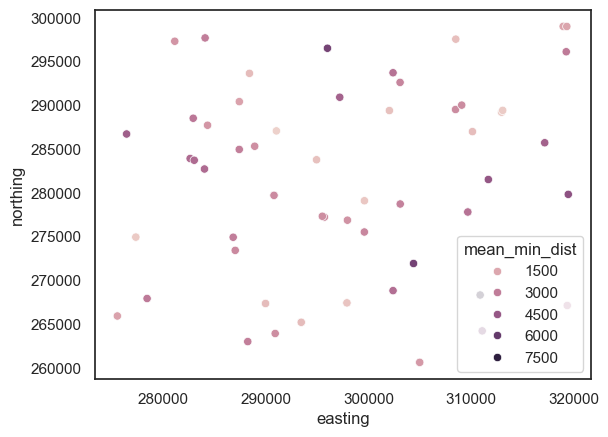

In [830]:
sns.scatterplot(x='easting', y='northing', hue='mean_min_dist', data=gauge_vs_grid_df)

Text(0.5, 1.0, 'HadUK-Grid')

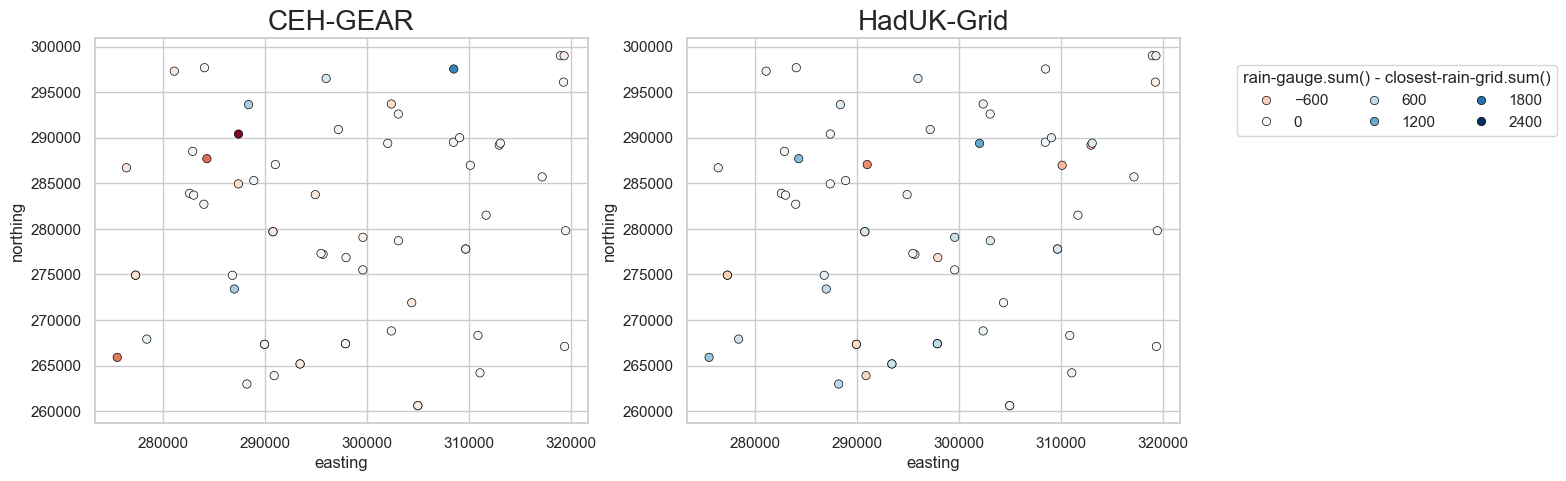

In [832]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='easting', y='northing', hue='sum_closest_ceh_diff', data=gauge_vs_grid_df, palette='RdBu', hue_norm=(-2400, 2400), edgecolor='k', legend=False, ax=axes[0])
sns.scatterplot(x='easting', y='northing', hue='sum_closest_haduk_diff', data=gauge_vs_grid_df, palette='RdBu', hue_norm=(-2400, 2400), edgecolor='k', ax=axes[1])


handles, labels  =  axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, bbox_to_anchor=(1.1, .95), ncols=3, title='rain-gauge.sum() - closest-rain-grid.sum()')

axes[0].set_title('CEH-GEAR', size=20)
axes[1].set_title('HadUK-Grid', size=20)

## Nearby grid

Text(0.5, 1.0, 'HadUK-Grid')

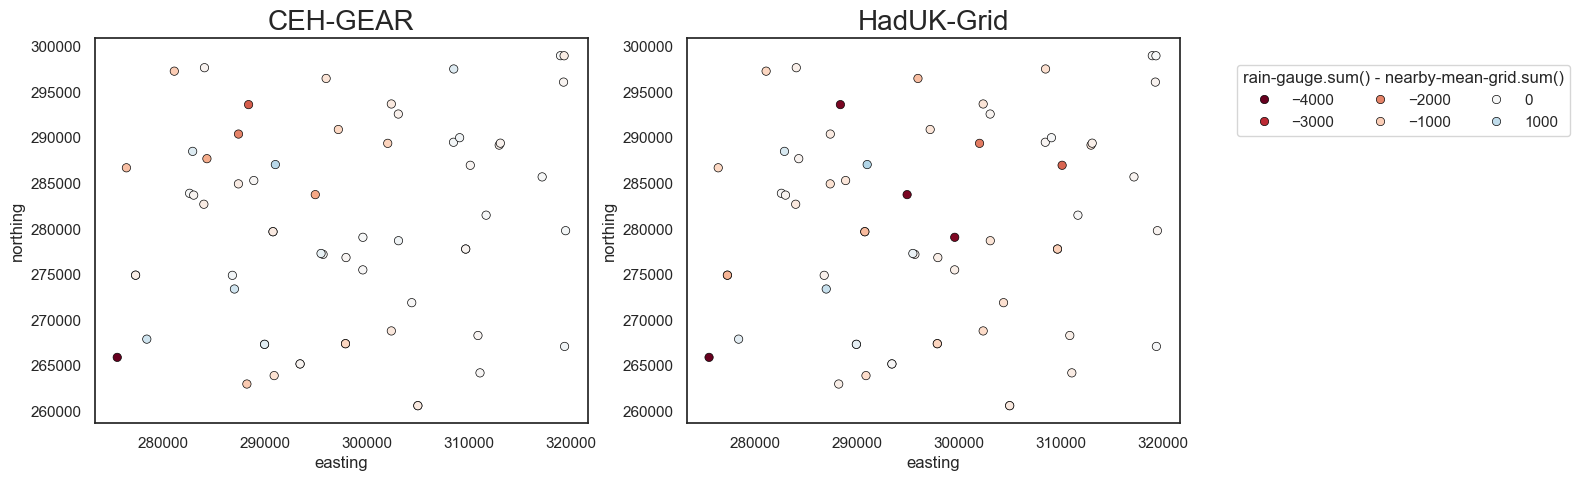

In [742]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='easting', y='northing', hue='sum_nearby_ceh_diff', data=gauge_vs_grid_df, palette='RdBu', hue_norm=(-4000, 4000), edgecolor='k', legend=False, ax=axes[0])
sns.scatterplot(x='easting', y='northing', hue='sum_nearby_haduk_diff', data=gauge_vs_grid_df, palette='RdBu', hue_norm=(-4000, 4000), edgecolor='k', ax=axes[1])


handles, labels  =  axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, bbox_to_anchor=(1.1, .95), ncols=3, title='rain-gauge.sum() - nearby-mean-grid.sum()')

axes[0].set_title('CEH-GEAR', size=20)
axes[1].set_title('HadUK-Grid', size=20)

## Look at flood events

In [750]:
## Severn-wide flood events (from: https://github.com/Thomasjkeel/FDRI-catchment-contribution-to-floods)
severn_flood_dates = ['2000-09-28', '2001-02-13', '2002-01-28', '2002-11-15', '2007-01-01', '2008-03-17','2008-11-11']
severn_flood_dates = [datetime.datetime.strptime(flood_date + ' 09:00', "%Y-%m-%d %H:%M") for flood_date in severn_flood_dates]

In [881]:
flood_event_to_look_at = severn_flood_dates[1]
flood_event_to_look_at

datetime.datetime(2001, 2, 13, 9, 0)

In [882]:
def get_date_ndays_before(one_date, ndays):
    return one_date-datetime.timedelta(days=ndays)

In [883]:
def get_data_ndays_before_flood_date(data, flood_date):
    days_before = get_date_ndays_before(flood_date, ndays=10)
    return data.filter(
        (pl.col("time") >= days_before) & (pl.col("time") <= flood_date)
    )

In [886]:
gauge_vs_grid_flood_event_dict = {}

for gauge_id in all_plyn_gauge_ids:
    one_gauge = Gauge(gauge_id)
    ## Check if there is a less than n-Year overlap in times between gauge and expected start end
    gauge_start_time = one_gauge.gauge_data['time'].min() 
    gauge_end_time = one_gauge.gauge_data['time'].max()
    if compute_overlap_days(get_date_ndays_before(flood_event_to_look_at, 10), flood_event_to_look_at, gauge_start_time, gauge_end_time) < 10:
        print(gauge_id, 'not temporal overlap with event')
        continue
    gauge_vs_grid_flood_event_dict[gauge_id] = {}
    gauge_vs_grid_flood_event_dict[gauge_id]['easting'] = one_gauge.gauge_easting
    gauge_vs_grid_flood_event_dict[gauge_id]['northing'] = one_gauge.gauge_northing
    gauge_vs_grid_flood_event_dict[gauge_id]["mean_min_dist"] = float(one_gauge.closest_cehgear['min_dist'].mean())
    print("mean CEH min_dist=", gauge_vs_grid_flood_event_dict[gauge_id]["mean_min_dist"])
    combined_gauge_data = get_combined_gauge_data_w_nearby(one_gauge)
    combined_gauge_data_near_event = get_data_ndays_before_flood_date(combined_gauge_data.drop_nulls(col), flood_date=flood_event_to_look_at)
    for col in combined_gauge_data.columns[2:]: # TODO: not good practice, but this removes time and gauge data
        # gauge_vs_grid_flood_event_dict[gauge_id][f'{col}'] = combined_gauge_data_near_event
        gauge_vs_grid_flood_event_dict[gauge_id][f'{col}_diff'] = calc_sum_difference_from_gauge(combined_gauge_data_near_event, col)

420649 not temporal overlap with event
420655 not temporal overlap with event
420668 not temporal overlap with event
420708 not temporal overlap with event
420720 not temporal overlap with event
420803 not temporal overlap with event
mean CEH min_dist= 2380.523693679663
420828 not temporal overlap with event
mean CEH min_dist= 449.6078222778472
mean CEH min_dist= 662.6635481853833
421032 not temporal overlap with event
mean CEH min_dist= 864.2873826657175
421140 not temporal overlap with event
421152 not temporal overlap with event
421161 not temporal overlap with event
mean CEH min_dist= 107.50689924906324
421271 not temporal overlap with event
mean CEH min_dist= 643.8551470588194
421645 not temporal overlap with event
421646 not temporal overlap with event
421920 not temporal overlap with event
421953 not temporal overlap with event
421954 not temporal overlap with event
422073 not temporal overlap with event
422089 not temporal overlap with event
422091 not temporal overlap with eve

In [887]:
len(gauge_vs_grid_flood_event_dict.keys())

25

In [888]:
gauge_vs_grid_flood_df = pd.DataFrame.from_dict(gauge_vs_grid_flood_event_dict).T
gauge_vs_grid_flood_df = gauge_vs_grid_flood_df.reset_index(names='gauge_id')
gauge_vs_grid_flood_df

,gauge_id,easting,northing,mean_min_dist,rain_mm_closest_ceh_diff,rain_mm_closest_haduk_diff,rain_mm_nearby_ceh_diff,rain_mm_nearby_haduk_diff
0,420805,295500.0,277300.0,2380.523694,0.5,-1.004477,6.443333,4.700109
1,420868,299608.0,279072.0,449.607822,-0.2,1.256534,0.636000,-6.746300
2,420983,294936.0,283756.0,662.663548,-1.5,-2.755367,-5.988000,-7.614312
3,421090,288389.0,293631.0,864.287383,1.7,0.551840,-5.912000,-6.835878
4,421234,291018.0,287054.0,107.506899,0.0,-1.848772,3.568000,2.722897
5,421484,302044.0,289380.0,643.855147,-0.3,2.187914,-2.608000,-2.859862
6,422328,310149.0,286973.0,786.260779,0.5,-1.922375,1.488000,-5.453591
7,422493,308522.0,297540.0,704.870518,2.4,-0.004299,0.016000,-0.142709
8,422693,312987.0,289188.0,329.396269,-0.3,-1.270649,-1.496000,-0.581271
9,423008,319356.0,298991.0,1571.546433,-0.5,0.301890,-0.950000,-0.074277


Text(0.5, 1.0, 'HadUK-Grid')

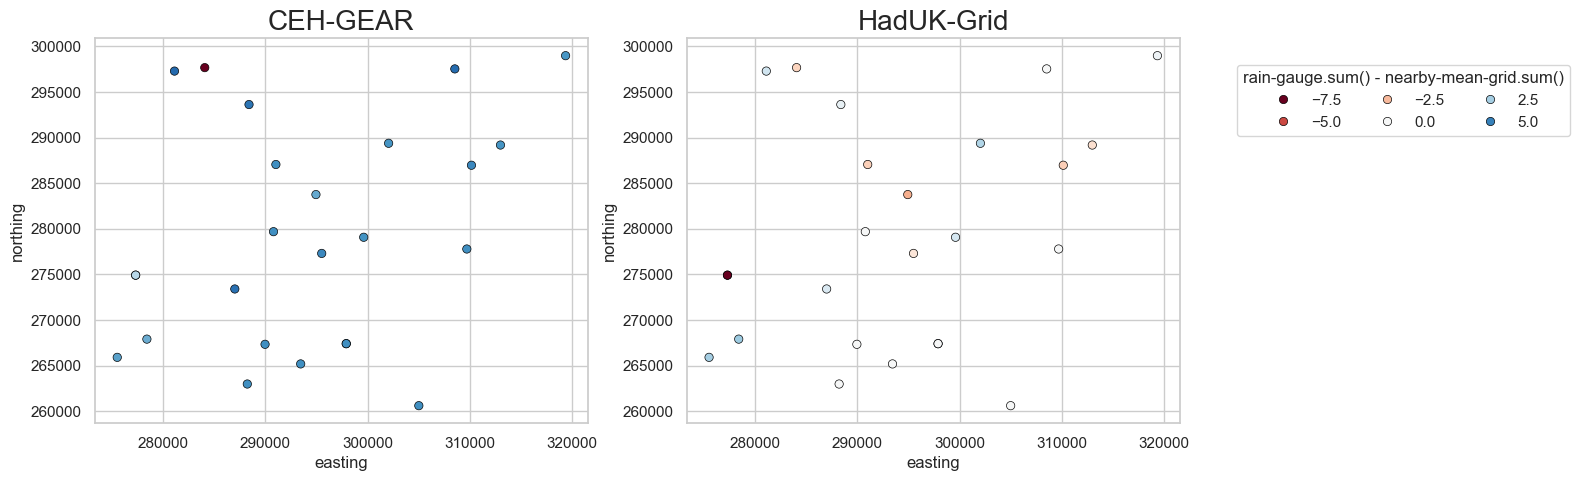

In [891]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='easting', y='northing', hue='rain_mm_closest_ceh_diff', data=gauge_vs_grid_flood_df, palette='RdBu', edgecolor='k', legend=False, ax=axes[0])
sns.scatterplot(x='easting', y='northing', hue='rain_mm_closest_haduk_diff', data=gauge_vs_grid_flood_df, palette='RdBu',  edgecolor='k', ax=axes[1])


handles, labels  =  axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, bbox_to_anchor=(1.1, .95), ncols=3, title='rain-gauge.sum() - nearby-mean-grid.sum()')

axes[0].set_title('CEH-GEAR', size=20)
axes[1].set_title('HadUK-Grid', size=20)

Text(0.5, 1.0, 'HadUK-Grid')

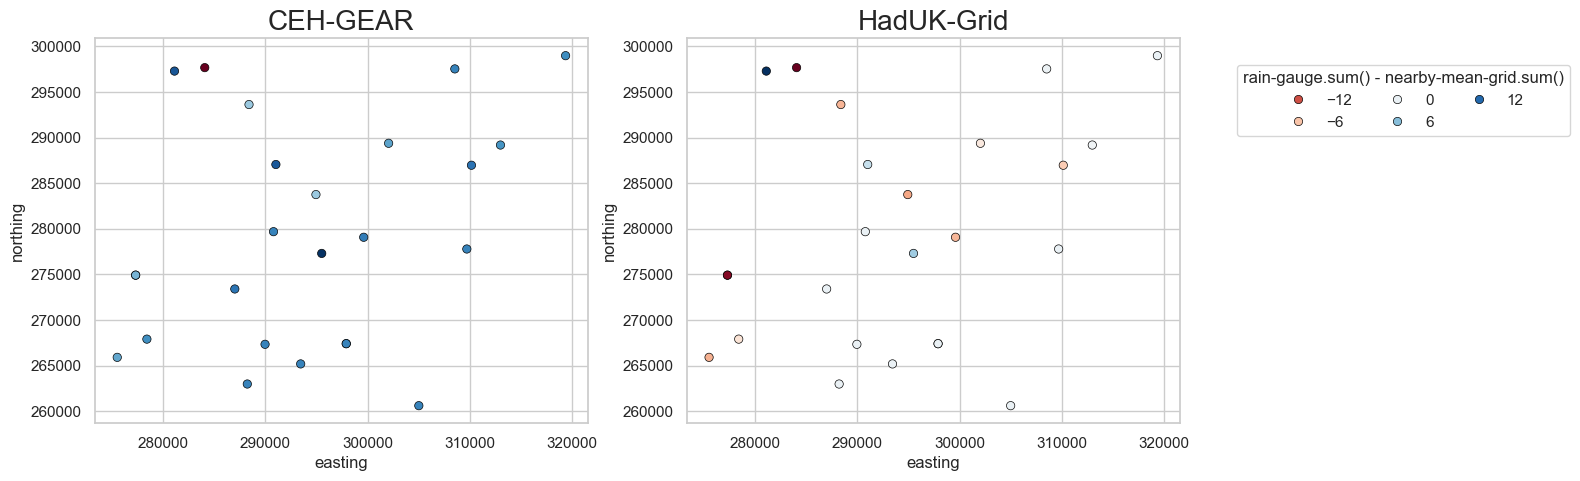

In [892]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='easting', y='northing', hue='rain_mm_nearby_ceh_diff', data=gauge_vs_grid_flood_df, palette='RdBu', edgecolor='k', legend=False, ax=axes[0])
sns.scatterplot(x='easting', y='northing', hue='rain_mm_nearby_haduk_diff', data=gauge_vs_grid_flood_df, palette='RdBu', edgecolor='k', ax=axes[1])


handles, labels  =  axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, bbox_to_anchor=(1.1, .95), ncols=3, title='rain-gauge.sum() - nearby-mean-grid.sum()')

axes[0].set_title('CEH-GEAR', size=20)
axes[1].set_title('HadUK-Grid', size=20)

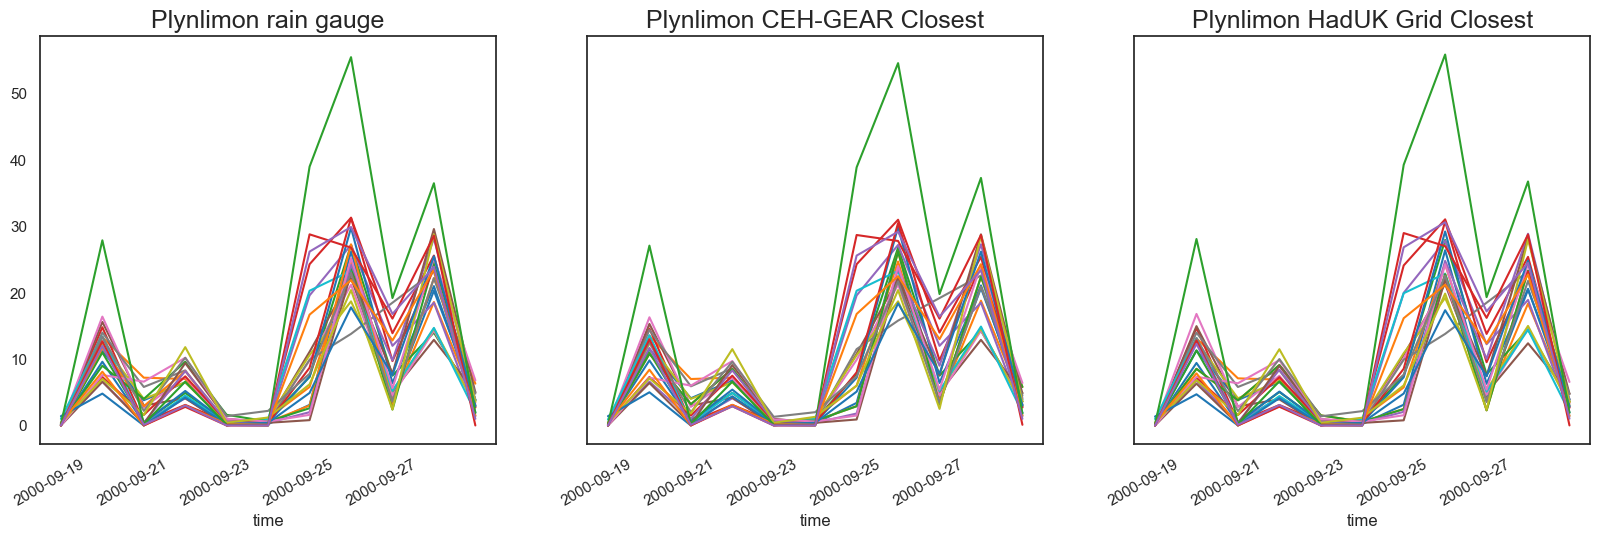

In [800]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True, sharex=True)
for gauge in gauge_vs_grid_flood_event_dict.keys():
    one_row = gauge_vs_grid_flood_event_dict[gauge]['rain_mm_closest_ceh'].to_pandas().set_index('time')
    one_row['rain_mm_gauge'].plot(ax=axes[0])
    one_row['rain_mm_closest_ceh'].plot(ax=axes[1])
    one_row['rain_mm_closest_haduk'].plot(ax=axes[2])

axes[0].set_title("Plynlimon rain gauge", size=18)
axes[1].set_title("Plynlimon CEH-GEAR Closest", size=18)
axes[2].set_title("Plynlimon HadUK Grid Closest", size=18)
plt.show()